<a href="https://colab.research.google.com/github/valmadrid/Detecting-Financial-Fraud-Transactions/blob/master/financial_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

import numpy as np

import pandas_profiling

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set_context("paper", font_scale=1.8)
sns.set_palette("GnBu_d")

#import io
#from google.colab import files 

***step*** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

***type*** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

***amount*** - amount of the transaction in local currency (assume $).

***nameOrig*** - customer who started the transaction

***oldbalanceOrg*** - initial balance before the transaction

***newbalanceOrig*** - new balance after the transaction

***nameDest*** - customer who is the recipient of the transaction

***oldbalanceDest*** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

***newbalanceDest*** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

***isFraud*** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

***isFlaggedFraud*** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than $200,000 in a single transaction.

In [0]:
uploaded = files.upload() 

Saving PS_20174392719_1491204439457_log.csv to PS_20174392719_1491204439457_log.csv


In [3]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv") 

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [0]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              6362620 non-null int64
type              6362620 non-null object
amount            6362620 non-null float64
nameOrig          6362620 non-null object
oldbalanceOrg     6362620 non-null float64
newbalanceOrig    6362620 non-null float64
nameDest          6362620 non-null object
oldbalanceDest    6362620 non-null float64
newbalanceDest    6362620 non-null float64
isFraud           6362620 non-null int64
isFlaggedFraud    6362620 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Rename column headers to indicate months
df.rename(mapper={
    "nameOrig": "customer",
    "oldbalanceOrg": "customer_old_balance",
    "newbalanceOrig": "customer_new_balance",
    "nameDest": "recipient",
    "oldbalanceDest": "recipient_old_balance",
    "newbalanceDest": "recipient_new_balance",
    "isFraud": "is_fraud",
    "isFlaggedFraud": "is_flagged_fraud"
},
          axis=1,
          inplace=True)

In [0]:
# Descriptive statistics
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,6.36262e+06,NaN,NaN,NaN,243.397,142.332,1,156,239,335,743
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,6.36262e+06,NaN,NaN,NaN,179862,603858,0,13389.6,74871.9,208721,9.24455e+07
customer,6362620,6353307,C724452879,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_old_balance,6.36262e+06,NaN,NaN,NaN,833883,2.88824e+06,0,0,14208,107315,5.9585e+07
customer_new_balance,6.36262e+06,NaN,NaN,NaN,855114,2.92405e+06,0,0,0,144258,4.9585e+07
recipient,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recipient_old_balance,6.36262e+06,NaN,NaN,NaN,1.1007e+06,3.39918e+06,0,0,132706,943037,3.56016e+08
recipient_new_balance,6.36262e+06,NaN,NaN,NaN,1.225e+06,3.67413e+06,0,0,214661,1.11191e+06,3.56179e+08
is_fraud,6.36262e+06,NaN,NaN,NaN,0.00129082,0.0359048,0,0,0,0,1


In [6]:
df.head()

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
repeated_customer_index = df[df.customer.duplicated(keep=False) == True].index

repeated_recipie_index = df[df.recipient.duplicated(keep=False) == True].index

In [ ]:
for i in range(len(df)):
    if df.customer.iloc[i] == df.customer.iloc[i - 1] & df.step.iloc[
            i] >= df.step.iloc[i - 1] & df.is_fraud.iloc[i - 1] == 1:
        continue

In [14]:
repeated_recipient = df[df.recipient.duplicated(keep=False) == True][[
    "step", "recipient", "is_fraud"
]].sort_values(["recipient", "step"]).reset_index(drop=False)

In [19]:
repeated_recipient

,index,step,recipient,is_fraud
0,4987517,352,C1000004082,0
1,5032095,354,C1000004082,0
2,5219127,370,C1000004082,0
3,5331822,374,C1000004082,0
4,5462768,379,C1000004082,0
...,...,...,...,...
4099911,1903740,165,M995849630,0
4099912,1360106,138,M995979279,0
4099913,2119013,183,M995979279,0
4099914,2724019,211,M998131649,0


In [20]:
for i in range(1, 1000000):
    if (repeated_recipient.recipient.iloc[i] == repeated_recipient.recipient.
            iloc[i - 1]) & (repeated_recipient.step.iloc[i] >
                            repeated_recipient.step.iloc[i - 1]) & (
                                repeated_recipient.is_fraud.iloc[i - 1] == 1):
        repeated_recipient.at[i, "recipient_with_prior"] = 1
    else:
        repeated_recipient.at[i,"recipient_with_prior"] = 0

repeated_recipient.set_index("index", drop=True, inplace=True)
repeated_recipient

,step,recipient,is_fraud,recipient_with_prior
index,,,,
4987517,352,C1000004082,0,NaN
5032095,354,C1000004082,0,0.0
5219127,370,C1000004082,0,0.0
5331822,374,C1000004082,0,0.0
5462768,379,C1000004082,0,0.0
...,...,...,...,...
1903740,165,M995849630,0,NaN
1360106,138,M995979279,0,NaN
2119013,183,M995979279,0,NaN


In [23]:
repeated_recipient.query("recipient_with_prior == 1 & is_fraud == 0").value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [0]:
print(list(df.select_dtypes(exclude="object").columns))

['step', 'amount', 'customer_old_balance', 'customer_new_balance', 'recipient_old_balance', 'recipient_new_balance', 'is_fraud', 'is_flagged_fraud']


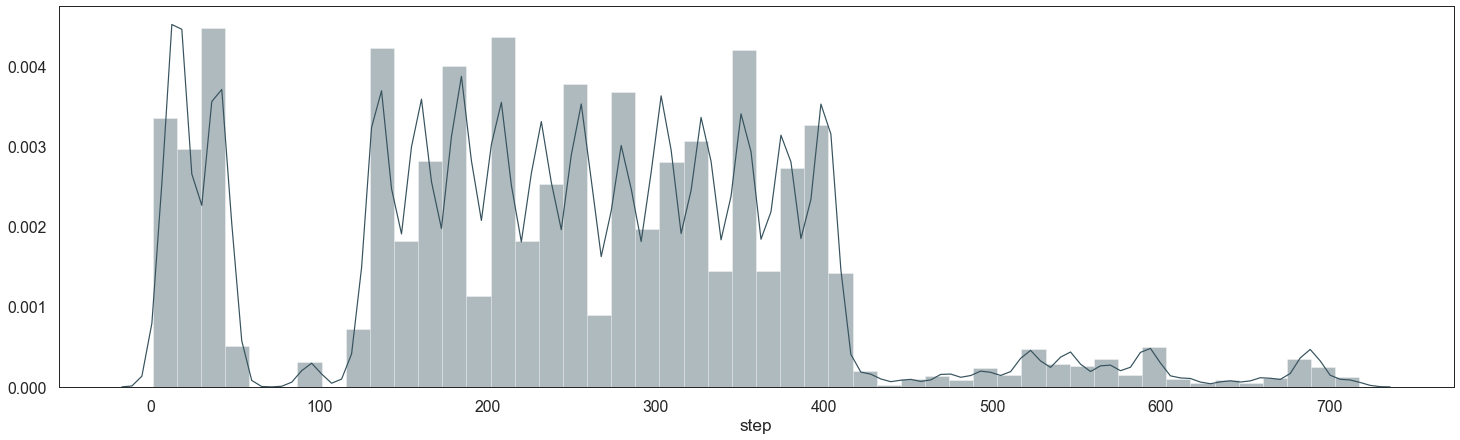

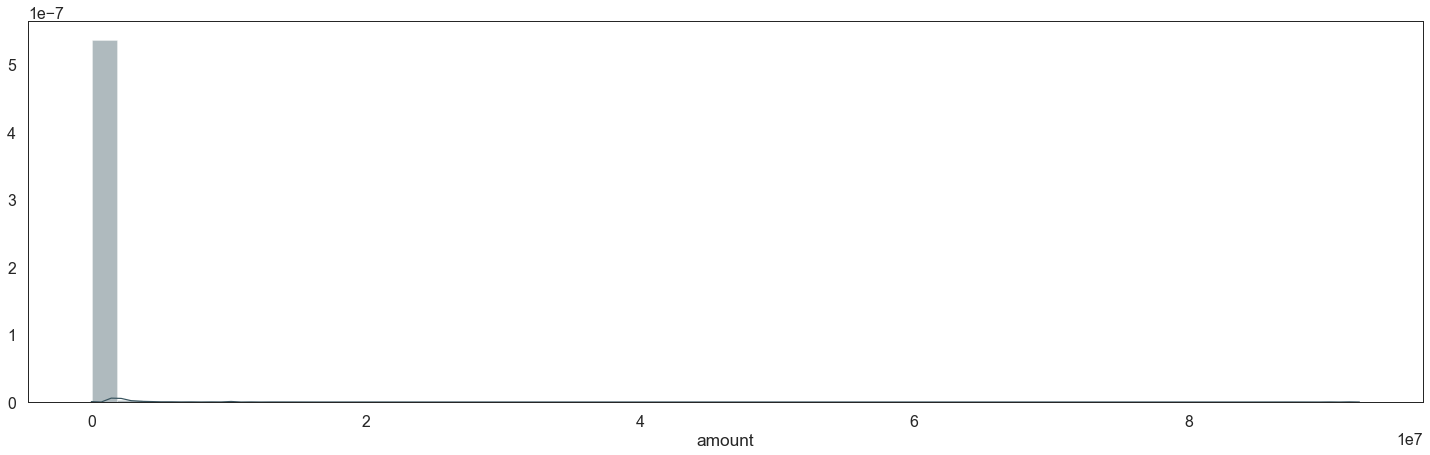

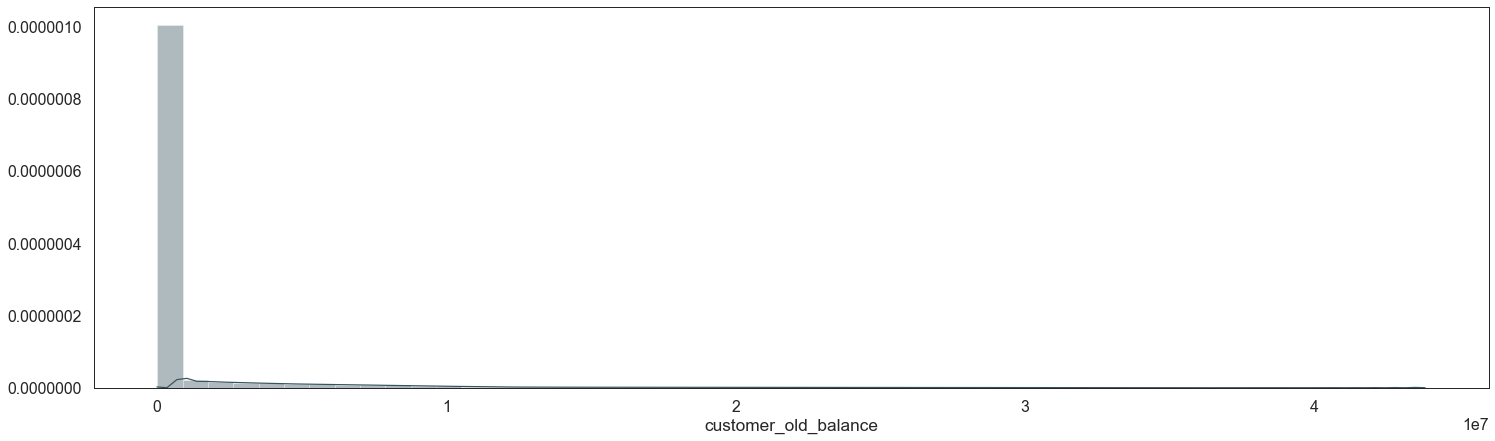

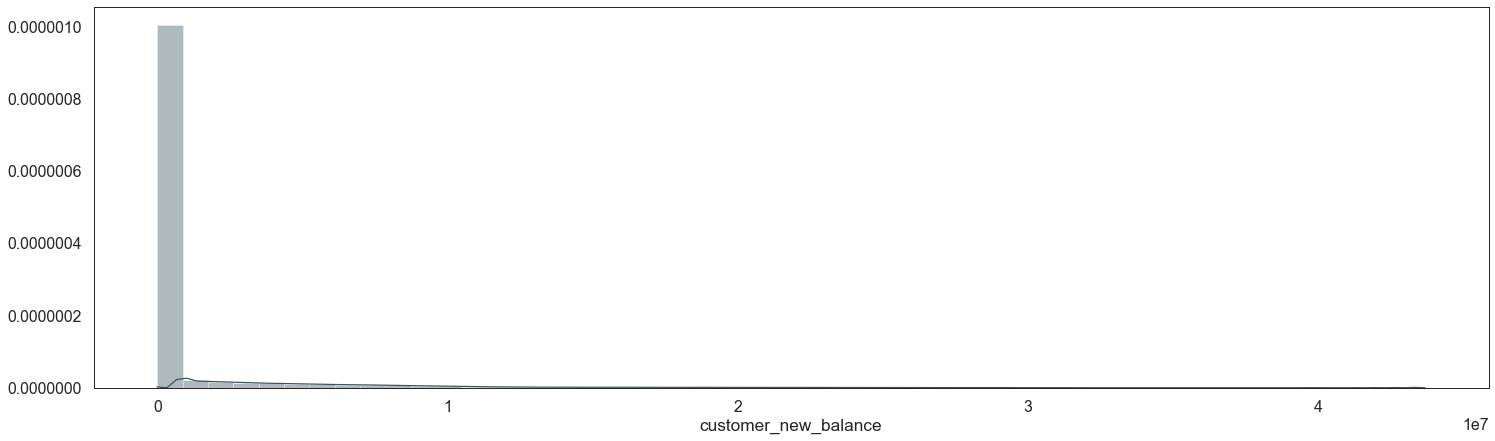

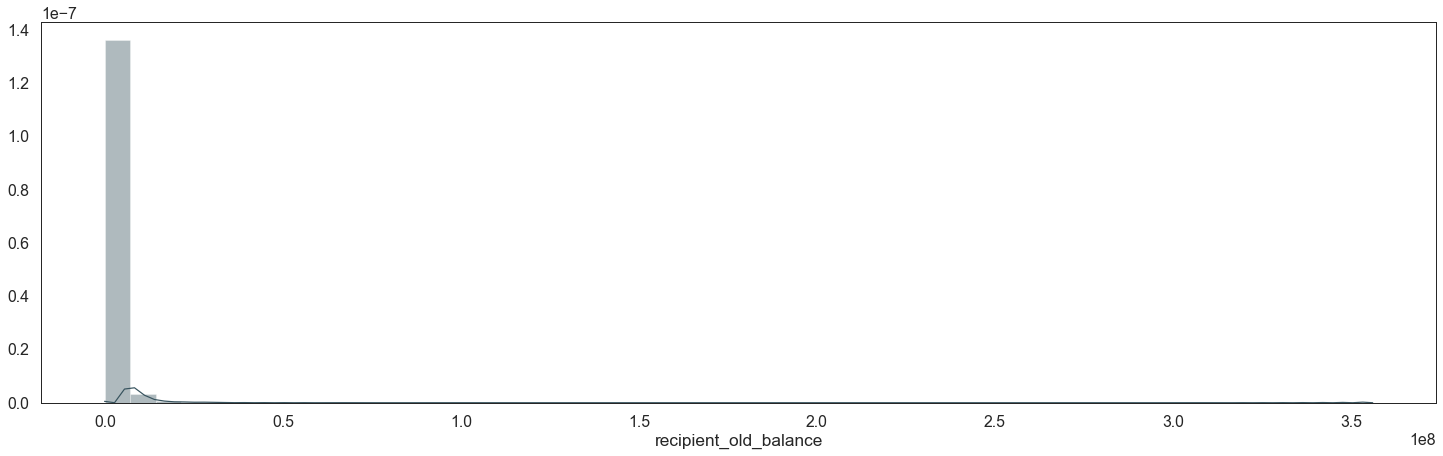

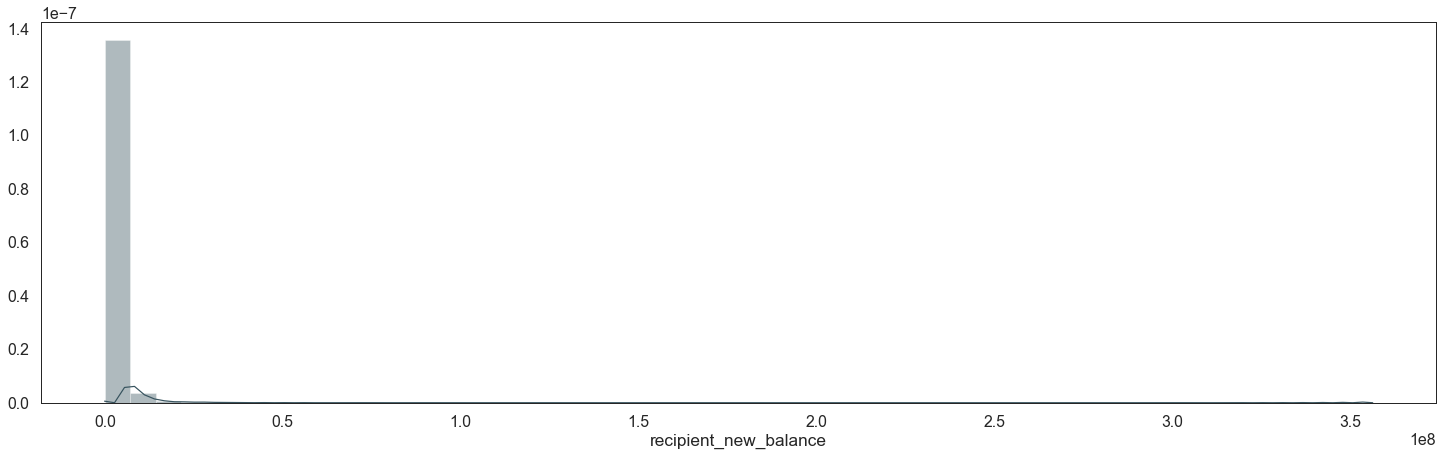

In [0]:
cols = [
    'step', 'amount', 'customer_old_balance', 'customer_new_balance',
    'recipient_old_balance', 'recipient_new_balance'
]
for col in cols:
    plt.figure(figsize=(25, 7))
    sns.distplot(df.query("is_fraud == 0")[col])
    plt.show()

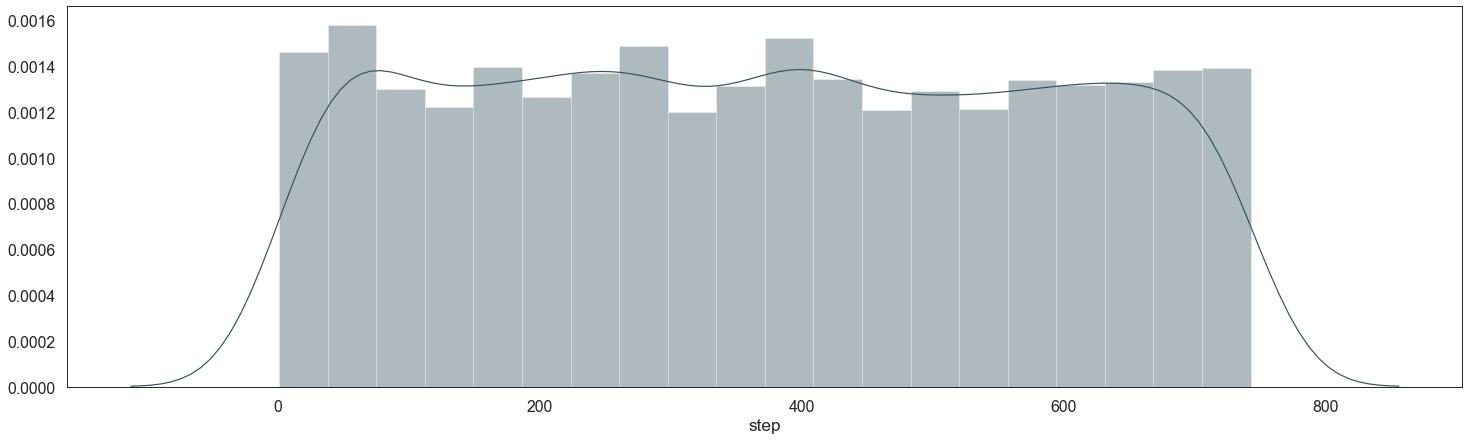

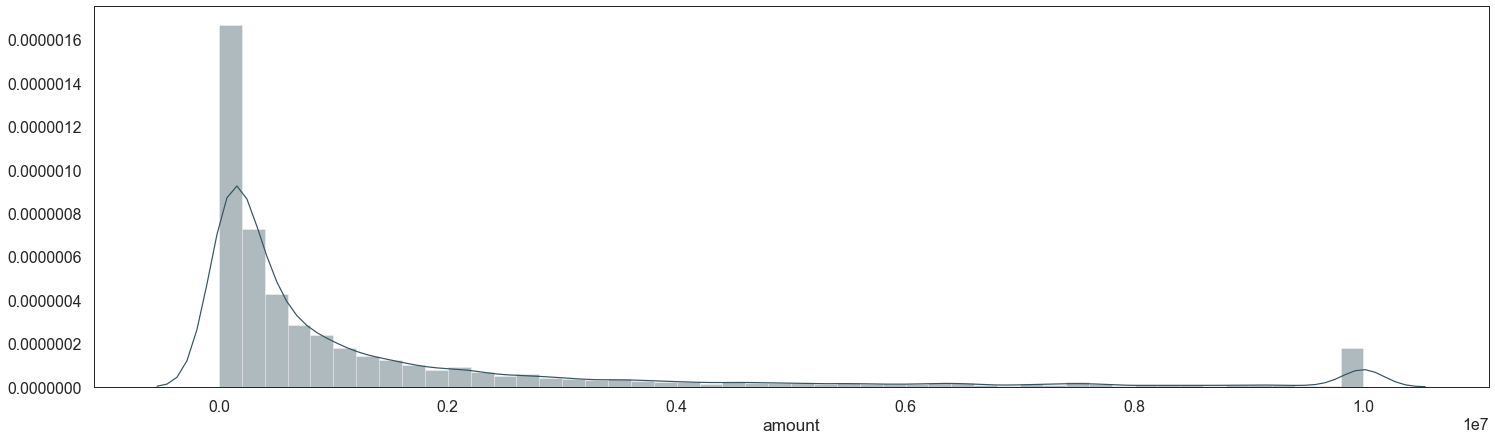

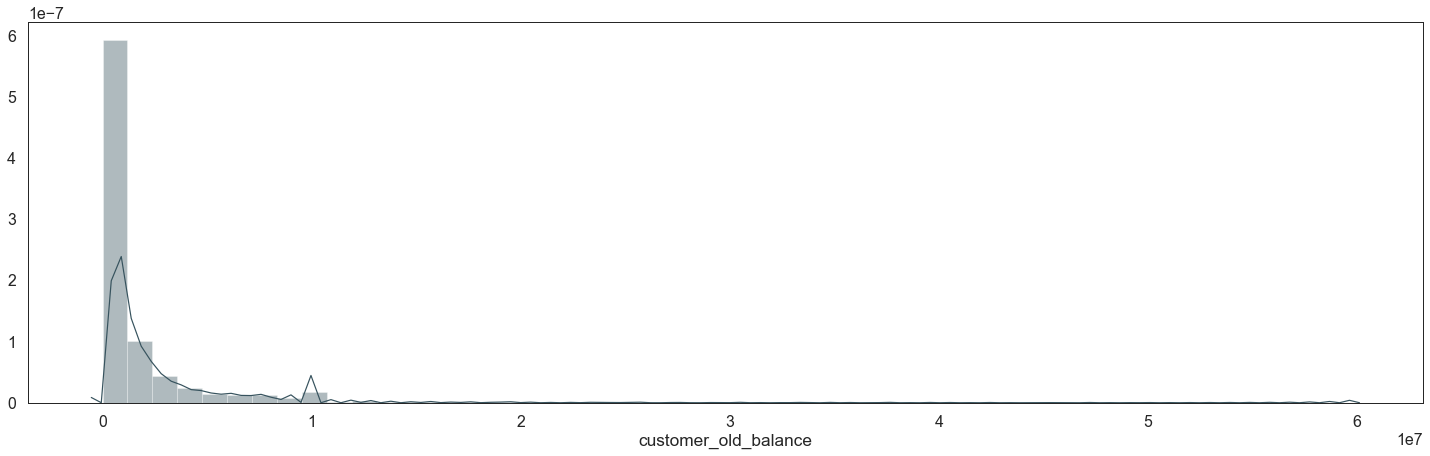

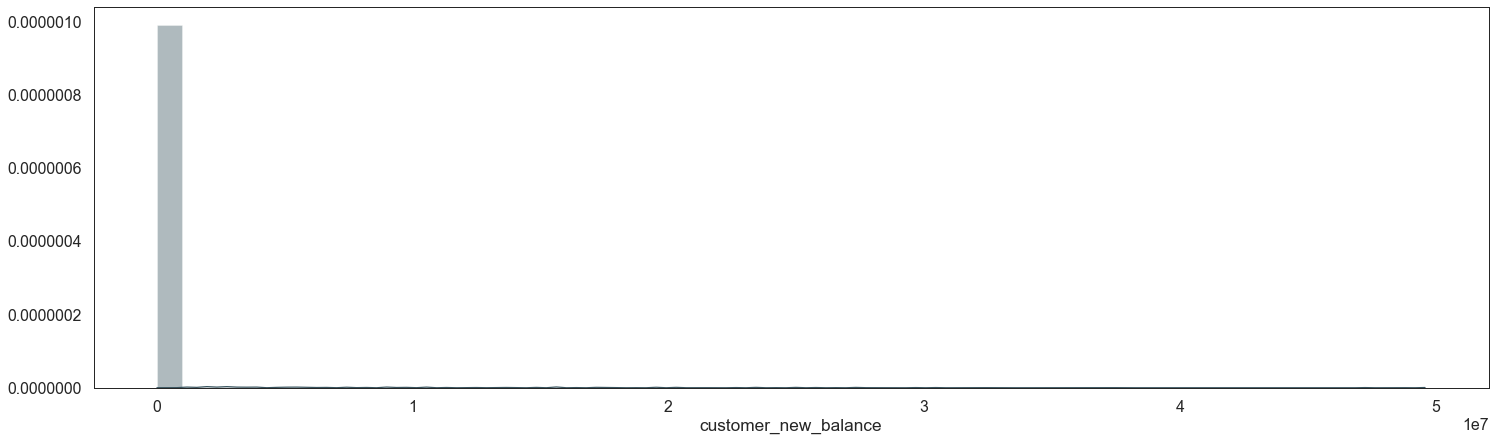

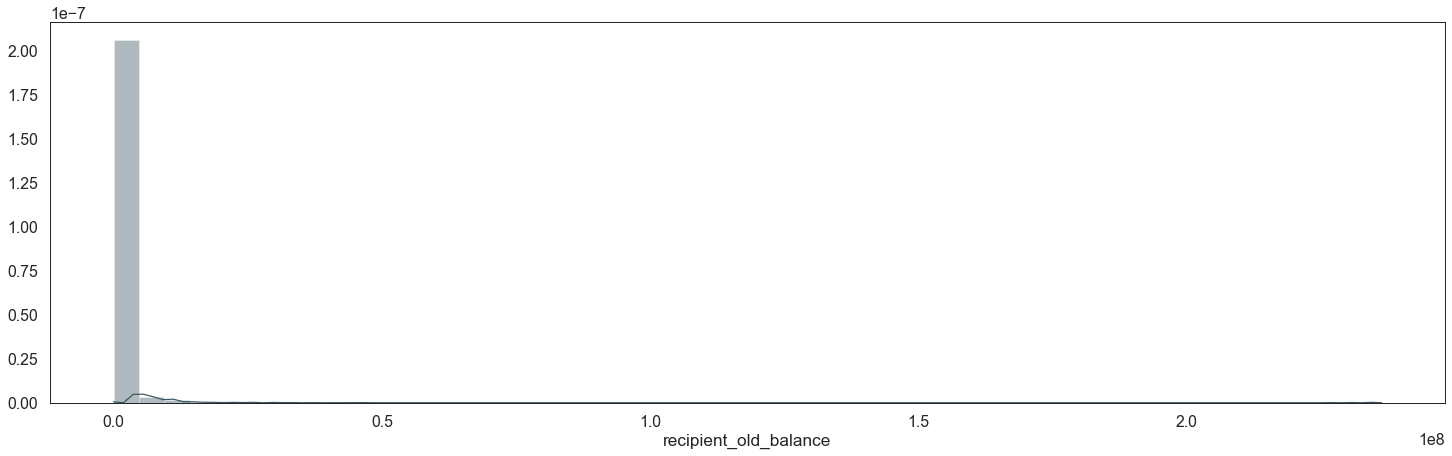

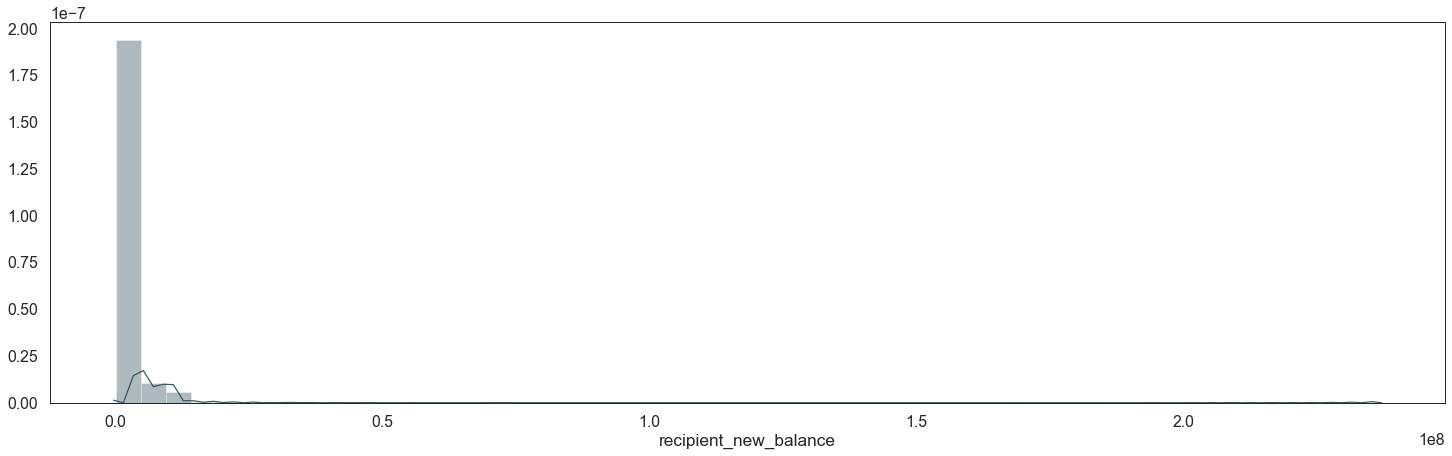

In [0]:
cols = [
    'step', 'amount', 'customer_old_balance', 'customer_new_balance',
    'recipient_old_balance', 'recipient_new_balance'
]
for col in cols:
    plt.figure(figsize=(25, 7))
    sns.distplot(df.query("is_fraud == 1")[col])
    plt.show()

In [0]:
for col in df.columns:
    print("FEATURE: ", col)
    print(df[col].value_counts(normalize=True).head(10))

FEATURE:  step
19     0.008071
18     0.007792
187    0.007714
235    0.007464
307    0.007382
163    0.007285
139    0.007238
403    0.007097
43     0.007082
355    0.007039
Name: step, dtype: float64
FEATURE:  type
CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64
FEATURE:  amount
10000000.0    0.000504
10000.0       0.000014
5000.0        0.000012
15000.0       0.000011
500.0         0.000010
100000.0      0.000007
21500.0       0.000006
120000.0      0.000005
135000.0      0.000003
0.0           0.000003
Name: amount, dtype: float64
FEATURE:  customer
C724452879     4.715039e-07
C400299098     4.715039e-07
C1784010646    4.715039e-07
C2051359467    4.715039e-07
C1462946854    4.715039e-07
C1677795071    4.715039e-07
C1530544995    4.715039e-07
C1832548028    4.715039e-07
C2098525306    4.715039e-07
C1999539787    4.715039e-07
Name: customer, dtype: float64
FEATURE:  customer_old_balance
0.0      0.330